In [ ]:
pip install altair
pip install nbformat
pip install fanalysis

In [304]:
import pandas as pd
import geopandas as gpd 
import folium
from altair import Chart
from fanalysis.ca import CA
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%pip install openpyxl

In [12]:
%run 0-nettoyage-bdd-v2.ipynb

In [157]:
base=nettoyer_lic_comm("https://www.data.gouv.fr/fr/datasets/r/9b002e32-0ec9-40fc-9292-cddeae4416c6","https://www.insee.fr/fr/statistiques/fichier/4989724/ensemble.xlsx")

C:\Users\user\AppData\Local\Temp\ipykernel_2612\775948522.py:5: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  lic_comm = pd.read_csv(chemin_acces_lic_comm, encoding="utf-8", sep=";")


In [159]:
base['Région'].unique()

<StringArray>
[      'Auvergne-Rhône-Alpes',            'Hauts-de-France',
 "Provence-Alpes-Côte d'Azur",                  'Grand Est',
                  'Occitanie',                  'Normandie',
         'Nouvelle-Aquitaine',        'Centre-Val de Loire',
    'Bourgogne-Franche-Comté',                   'Bretagne',
                      'Corse',           'Pays de la Loire',
              'Île-de-France',                       'DROM']
Length: 14, dtype: string

In [145]:
#### taux de licenciés par régions
def proportion_licencies_region(base):
    base_region=base[["Région","nb_licencies"]].groupby('Région').sum().reset_index()
    pop_region=pd.read_excel("https://www.insee.fr/fr/statistiques/fichier/4989724/ensemble.xlsx",sheet_name=0,skiprows=7)
    base_region=pd.merge(base_region,pop_region,left_on="Région", right_on="Nom de la région")
    base_region["taux_licencies"]=(base_region['nb_licencies']/base_region['Population municipale'])*100
    base_region



In [146]:
#les sports plus pratiques par regions
base_max=base[["Région",'Fédération',"nb_licencies"]].groupby(['Région','Fédération']).sum().reset_index()


#les sports plus pratiqués par régions
base_max=base[["Région",'Fédération',"nb_licencies"]].groupby(['Région','Fédération']).sum().reset_index()
#On retire les fdérations qui ne précisent pas le sport pratiqué (UNSS, )
base_max = base_max[(base_max["Fédération"]!= "FF Sports Pour Tous") &
                                  (base_max["Fédération"]!= "FF du Sport Universitaire") &
                                  (base_max["Fédération"]!= "F Sportive Educative de l'Enseignement Catholique (UGSEL)") &
                                  (base_max["Fédération"]!= "Union Française des Œuvres Laïques d'Éducation Physique (UFOLEP)") &
                                  (base_max["Fédération"]!= "Union Nationale du Sport Scolaire (UNSS)") &
                                  (base_max["Fédération"]!= "Union Sportive de l'Enseignement du Premier Degré ") &
                                  (base_max["Fédération"]!= "F Sportive et Gymnique du Travail") &
                                  (base_max["Fédération"]!= "FF de la Retraite Sportive")]


#Hors UNSS 
base_max = base_max[base_max['Fédération'] != "F Sportive Educative de l'Enseignement Catholique (UGSEL)"]
base_max = base_max[base_max['Fédération'] != "Union Sportive de l'Enseignement du Premier Degré"]
base_max = base_max[base_max['Fédération'] != "Union Nationale du Sport Scolaire (UNSS)"]

In [170]:
#las 10 sports les plus pratriqués par régions.
def sports_plus_pratiques_par_region(base):
    #creation carte
    carte_france=folium.Map(location=[46.6031, 1.8883],tiles="OpenStreetMap", zoom_start=6)
    #importation shapefile
    reg_shape2=gpd.read_file("https://osm13.openstreetmap.fr/~cquest/openfla/export/regions-20180101-shp.zip")
        #creations des entroidespou les marqueurs
    reg_shape2['centroid']=reg_shape2.centroid
    #ajout des marqueurs
    for _, r in reg_shape2.iterrows():
            lat = r["centroid"].y
            lon = r["centroid"].x
            marker = folium.Marker(location=[lat, lon])
            popup = folium.Popup()
            if r['nom'] in ['Guyane','Mayotte','Guadeloupe','Martinique','La Réunion']: 
                nom_region='DROM'
            else: nom_region=r['nom']       
            data=base.loc[base['Région']==nom_region]
            data=data.sort_values(by = 'nb_licencies', ascending = False).head(10)
            #creation graphique à incorporer aux pop up
            bar_plot = (
                Chart(data)
                .mark_bar()
                .encode(
                    x="Fédération",
                    y="nb_licencies",
                    #color="Origin",
                )
            )
            vega_lite = folium.VegaLite(
            bar_plot,
            width="100%",
            height="100%",
            )
            vega_lite.add_to(popup)
            popup.add_to(marker)
            marker.add_to(carte_france)
  

    #aajouts des couches
    for _, r in reg_shape2.iterrows():
            # Without simplifying the representation of each borough,
            # the map might not be displayed
            sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
            geo_j = sim_geo.to_json()
            geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
            folium.Popup(r["nom"]).add_to(geo_j)
            geo_j.add_to(carte_france)

    return carte_france

In [171]:
sports_plus_pratiques_par_region(base_max)

C:\Users\user\AppData\Local\Temp\ipykernel_2612\1443833285.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  reg_shape2['centroid']=reg_shape2.centroid


In [161]:
##  tableau élargi
base_max['Région'].unique()

<StringArray>
[      'Auvergne-Rhône-Alpes',    'Bourgogne-Franche-Comté',
                   'Bretagne',        'Centre-Val de Loire',
                      'Corse',                       'DROM',
                  'Grand Est',            'Hauts-de-France',
                  'Normandie',         'Nouvelle-Aquitaine',
                  'Occitanie',           'Pays de la Loire',
 "Provence-Alpes-Côte d'Azur",              'Île-de-France']
Length: 14, dtype: string

In [269]:
base_pivot = pd.pivot_table(base_max, values='nb_licencies', index='Région', columns='Fédération', fill_value=0)
base_pivot=base_pivot.reset_index()
base_pivot=base_pivot.rename_axis(None, axis=1).reset_index(drop=True)
base_pivot

,Région,F Nationale du Sport en Milieu Rural,F Nautique de Pêche Sportive en Apnée,F Sportive des ASPTT,F des Arts Énergétiques et Martiaux Chinois,FF Aéronautique,FF Handisport,FF Motonautique,FF Omnisports des Personnels de l'Éducation Nationale,FF Sportive de Twirling Bâton,...,FF des Sports de Glace,"FF des Sports de Traîneau, de Ski VTT Joëring et de Canicross",FF des Échecs,FF du Sport Adapté,FF du Sport Automobile,FF du Sport Boules,FF du Sport Travailliste,FF du Sport d'Entreprise,Union Nationale Sportive Léo Lagrange,Union Nationale des Clubs Universitaires
0,Auvergne-Rhône-Alpes,3875.0,10.0,14304.0,2181.0,4466.0,3634.0,29.0,1596.0,2776.0,...,3729.0,281.0,1811.0,6258.0,6540.0,29130.0,2150.0,574.0,4333.0,18281.0
1,Bourgogne-Franche-Comté,798.0,4.0,7042.0,548.0,1633.0,2021.0,23.0,109.0,545.0,...,1380.0,60.0,737.0,2634.0,3034.0,3229.0,510.0,161.0,1153.0,31.0
2,Bretagne,4645.0,129.0,7857.0,655.0,1851.0,1429.0,7.0,333.0,1787.0,...,1111.0,27.0,1360.0,2602.0,1016.0,307.0,878.0,298.0,872.0,27.0
3,Centre-Val de Loire,390.0,2.0,11104.0,1142.0,1406.0,795.0,5.0,1040.0,914.0,...,1214.0,19.0,789.0,2152.0,1800.0,806.0,652.0,829.0,224.0,846.0
4,Corse,6.0,34.0,955.0,0.0,351.0,27.0,13.0,0.0,93.0,...,0.0,9.0,145.0,49.0,1200.0,2.0,56.0,36.0,0.0,9.0
5,DROM,206.0,13.0,1488.0,568.0,635.0,527.0,31.0,429.0,1058.0,...,3.0,0.0,327.0,360.0,847.0,6.0,946.0,1492.0,4.0,11.0
6,Grand Est,1501.0,5.0,17889.0,1254.0,2483.0,2710.0,5.0,989.0,1730.0,...,3064.0,135.0,2933.0,3050.0,2613.0,578.0,1589.0,2013.0,1194.0,51.0
7,Hauts-de-France,6238.0,20.0,6464.0,1463.0,2270.0,2532.0,6.0,263.0,1409.0,...,1537.0,57.0,1554.0,3537.0,2341.0,930.0,2176.0,196.0,4605.0,8296.0
8,Normandie,8228.0,165.0,9409.0,359.0,1475.0,595.0,147.0,90.0,1118.0,...,1686.0,37.0,985.0,2375.0,2740.0,639.0,352.0,49.0,1830.0,2526.0
9,Nouvelle-Aquitaine,3693.0,187.0,14851.0,2209.0,4325.0,2473.0,37.0,1253.0,1865.0,...,1871.0,82.0,1689.0,10366.0,3561.0,1722.0,1670.0,176.0,2304.0,1123.0


In [232]:
 def sports_parmi_les_5_sports_pus_pratiques(base):
    list_region=base['Région'].unique()
    data=[]
    for region in list_region:
        top_5=base[base['Région']==region].sort_values(by='nb_licencies',ascending=False).head(5)['Fédération'].tolist()
        data.append(top_5)
    # Concaténation des sous-listes en une seule liste
    federations_concatenees = [federation for sublist in data for federation in sublist]

    # Obtention des valeurs uniques
    top_5= list(set(federations_concatenees))
    return top_5


In [237]:

top_5=sports_parmi_les_5_sports_pus_pratiques(base_max)

In [313]:
base_afc=base_pivot[["Région"]+top_5]

In [314]:
base_afc

,Région,FF de Tir,FF de Basketball,FF de Handball,FF de Golf,FF de Tennis,FF de Football,"FF de Judo, Jujitsu, Kendo et DA",FF de Voile,FF de Pétanque et Jeu Provençal,FF de Natation,FF d'Équitation,FF d'Éducation Physique et de Gymnastique Volontaire,FF d'Athlétisme,FF de Rugby
0,Auvergne-Rhône-Alpes,26240.0,74890.0,51195.0,47145.0,122613.0,266445.0,59804.0,20452.0,43544.0,49393.0,73368.0,77736.0,31453.0,53813.0
1,Bourgogne-Franche-Comté,11801.0,16195.0,23644.0,10197.0,28418.0,99068.0,22437.0,4218.0,15462.0,15836.0,29033.0,20333.0,12551.0,12840.0
2,Bretagne,6824.0,32974.0,34133.0,17143.0,42636.0,153033.0,25731.0,29142.0,10904.0,10533.0,32558.0,19465.0,17731.0,10424.0
3,Centre-Val de Loire,8765.0,21704.0,21725.0,11934.0,37726.0,89123.0,22610.0,5834.0,10527.0,11296.0,28682.0,32952.0,12415.0,10621.0
4,Corse,5112.0,1102.0,1740.0,1473.0,3731.0,9947.0,2213.0,2599.0,2397.0,1887.0,2581.0,1532.0,1652.0,1104.0
5,DROM,2349.0,9016.0,13126.0,4856.0,14782.0,58110.0,9472.0,4039.0,4993.0,10260.0,6091.0,4522.0,11629.0,5088.0
6,Grand Est,27144.0,39422.0,45685.0,23124.0,70033.0,216172.0,43508.0,6973.0,17614.0,32058.0,53346.0,29491.0,26133.0,10022.0
7,Hauts-de-France,16342.0,47723.0,33177.0,25465.0,67858.0,234283.0,46835.0,9851.0,14402.0,24593.0,58550.0,25410.0,27672.0,10760.0
8,Normandie,10126.0,23292.0,30692.0,18369.0,44753.0,115579.0,28714.0,19096.0,10639.0,15405.0,37072.0,30576.0,16169.0,8081.0
9,Nouvelle-Aquitaine,20074.0,53096.0,55358.0,45823.0,88817.0,197090.0,51115.0,18717.0,34283.0,28328.0,62229.0,65692.0,28875.0,64150.0


In [284]:
type(base_afc)

pandas.core.frame.DataFrame

### Distribution du nbres de licencies par région par sport

In [291]:
### extraction des noms de colonnes et de la colonne Région
col_names=list(base_afc.columns)[1:]
nom_region=base_afc['Région']

In [294]:
#extraction des données numériques
X=base_afc[col_names]
X

,FF de Tir,FF de Basketball,FF de Handball,FF de Golf,FF de Tennis,FF de Football,"FF de Judo, Jujitsu, Kendo et DA",FF de Voile,FF de Pétanque et Jeu Provençal,FF de Natation,FF d'Équitation,FF d'Éducation Physique et de Gymnastique Volontaire,FF d'Athlétisme,FF de Rugby
0,26240.0,74890.0,51195.0,47145.0,122613.0,266445.0,59804.0,20452.0,43544.0,49393.0,73368.0,77736.0,31453.0,53813.0
1,11801.0,16195.0,23644.0,10197.0,28418.0,99068.0,22437.0,4218.0,15462.0,15836.0,29033.0,20333.0,12551.0,12840.0
2,6824.0,32974.0,34133.0,17143.0,42636.0,153033.0,25731.0,29142.0,10904.0,10533.0,32558.0,19465.0,17731.0,10424.0
3,8765.0,21704.0,21725.0,11934.0,37726.0,89123.0,22610.0,5834.0,10527.0,11296.0,28682.0,32952.0,12415.0,10621.0
4,5112.0,1102.0,1740.0,1473.0,3731.0,9947.0,2213.0,2599.0,2397.0,1887.0,2581.0,1532.0,1652.0,1104.0
5,2349.0,9016.0,13126.0,4856.0,14782.0,58110.0,9472.0,4039.0,4993.0,10260.0,6091.0,4522.0,11629.0,5088.0
6,27144.0,39422.0,45685.0,23124.0,70033.0,216172.0,43508.0,6973.0,17614.0,32058.0,53346.0,29491.0,26133.0,10022.0
7,16342.0,47723.0,33177.0,25465.0,67858.0,234283.0,46835.0,9851.0,14402.0,24593.0,58550.0,25410.0,27672.0,10760.0
8,10126.0,23292.0,30692.0,18369.0,44753.0,115579.0,28714.0,19096.0,10639.0,15405.0,37072.0,30576.0,16169.0,8081.0
9,20074.0,53096.0,55358.0,45823.0,88817.0,197090.0,51115.0,18717.0,34283.0,28328.0,62229.0,65692.0,28875.0,64150.0


In [300]:
#Calcul profil ligne
X=X.to_numpy()
row_sum=np.sum(X,axis=1)
row_profile=X/row_sum[:,np.newaxis]

#Affichage
print("Profil ligne:")
print(pd.DataFrame(row_profile,index=nom_region,columns=col_names))


Profil ligne:
                            FF de Tir  FF de Basketball  FF de Handball  \
Région                                                                    
Auvergne-Rhône-Alpes         0.026290          0.075033        0.051293   
Bourgogne-Franche-Comté      0.036645          0.050290        0.073421   
Bretagne                     0.015396          0.074395        0.077010   
Centre-Val de Loire          0.026894          0.066594        0.066659   
Corse                        0.130842          0.028206        0.044535   
DROM                         0.014836          0.056943        0.082901   
Grand Est                    0.042365          0.061527        0.071302   
Hauts-de-France              0.025418          0.074228        0.051604   
Normandie                    0.024784          0.057010        0.075122   
Nouvelle-Aquitaine           0.024672          0.065257        0.068037   
Occitanie                    0.029995          0.047405        0.055241   
Pays de la 

## Répartition des nbres de licencies par fédération selon les régions

In [303]:
#Calcul profil lcolonnes
col_sum=np.sum(X,axis=0)
col_profile=X/col_sum[np.newaxis,:]

#Affichage
print("Profil colonne:")
print(pd.DataFrame(col_profile,index=nom_region,columns=col_names))


Profil colonne:
                            FF de Tir  FF de Basketball  FF de Handball  \
Région                                                                    
Auvergne-Rhône-Alpes         0.117365          0.146114        0.104887   
Bourgogne-Franche-Comté      0.052783          0.031597        0.048441   
Bretagne                     0.030522          0.064334        0.069930   
Centre-Val de Loire          0.039204          0.042346        0.044509   
Corse                        0.022865          0.002150        0.003565   
DROM                         0.010506          0.017591        0.026892   
Grand Est                    0.121408          0.076914        0.093598   
Hauts-de-France              0.073094          0.093110        0.067972   
Normandie                    0.045291          0.045444        0.062881   
Nouvelle-Aquitaine           0.089786          0.103593        0.113416   
Occitanie                    0.101804          0.070183        0.085880   
Pays de l

### analyse des nbre de licencies

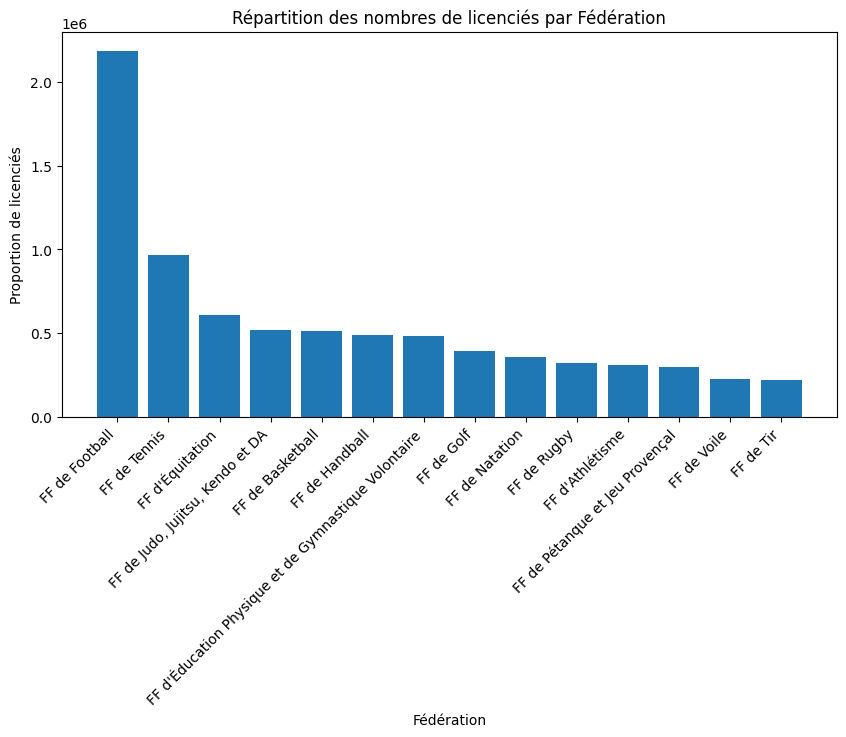

In [305]:
#calcul de la somme des nbres de licencies pour chaque fédération
total_lic=base_afc[col_names].sum()

#calcul des proportions pour chaque candidat
prop_lic=total_lic
#Tri des proportion par ordre décrossant
prop_lic=prop_lic.sort_values(ascending=False)
#Création du diagramme en barre
fig, ax= plt.subplots(figsize=(10,5))
ax.bar(prop_lic.index,prop_lic)

#ajout label et titres
ax.set_xlabel('Fédération')
ax.set_ylabel('Proportion de licenciés')
ax.set_title('Répartition des nombres de licenciés par Fédération')

#Rotation des noms des fédérations
plt.xticks(rotation=45,ha='right')

#affichage diagramme
plt.show()

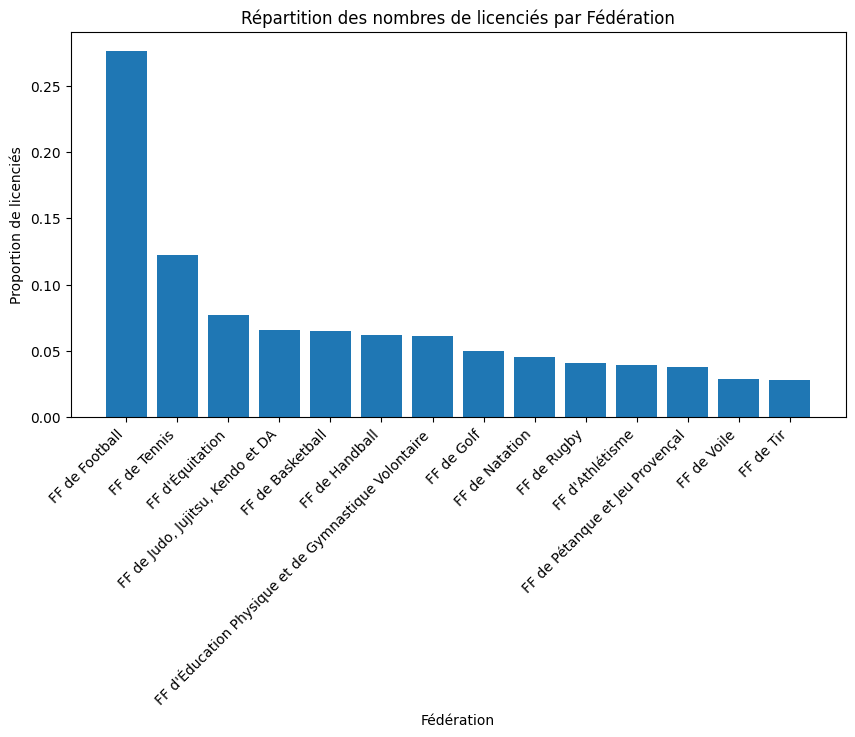

In [306]:
#calcul des proportions pour chaque candidat
prop_lic=total_lic/total_lic.sum()
#Tri des proportion par ordre décrossant
prop_lic=prop_lic.sort_values(ascending=False)
#Création du diagramme en barre
fig, ax= plt.subplots(figsize=(10,5))
ax.bar(prop_lic.index,prop_lic)

#ajout label et titres
ax.set_xlabel('Fédération')
ax.set_ylabel('Proportion de licenciés')
ax.set_title('Répartition des nombres de licenciés par Fédération')

#Rotation des noms des fédérations
plt.xticks(rotation=45,ha='right')

#affichage diagramme
plt.show()

#### AFC

In [320]:
base_afc=base_afc.set_index("Région")

In [321]:
base_afc

,FF de Tir,FF de Basketball,FF de Handball,FF de Golf,FF de Tennis,FF de Football,"FF de Judo, Jujitsu, Kendo et DA",FF de Voile,FF de Pétanque et Jeu Provençal,FF de Natation,FF d'Équitation,FF d'Éducation Physique et de Gymnastique Volontaire,FF d'Athlétisme,FF de Rugby
Région,,,,,,,,,,,,,,
Auvergne-Rhône-Alpes,26240.0,74890.0,51195.0,47145.0,122613.0,266445.0,59804.0,20452.0,43544.0,49393.0,73368.0,77736.0,31453.0,53813.0
Bourgogne-Franche-Comté,11801.0,16195.0,23644.0,10197.0,28418.0,99068.0,22437.0,4218.0,15462.0,15836.0,29033.0,20333.0,12551.0,12840.0
Bretagne,6824.0,32974.0,34133.0,17143.0,42636.0,153033.0,25731.0,29142.0,10904.0,10533.0,32558.0,19465.0,17731.0,10424.0
Centre-Val de Loire,8765.0,21704.0,21725.0,11934.0,37726.0,89123.0,22610.0,5834.0,10527.0,11296.0,28682.0,32952.0,12415.0,10621.0
Corse,5112.0,1102.0,1740.0,1473.0,3731.0,9947.0,2213.0,2599.0,2397.0,1887.0,2581.0,1532.0,1652.0,1104.0
DROM,2349.0,9016.0,13126.0,4856.0,14782.0,58110.0,9472.0,4039.0,4993.0,10260.0,6091.0,4522.0,11629.0,5088.0
Grand Est,27144.0,39422.0,45685.0,23124.0,70033.0,216172.0,43508.0,6973.0,17614.0,32058.0,53346.0,29491.0,26133.0,10022.0
Hauts-de-France,16342.0,47723.0,33177.0,25465.0,67858.0,234283.0,46835.0,9851.0,14402.0,24593.0,58550.0,25410.0,27672.0,10760.0
Normandie,10126.0,23292.0,30692.0,18369.0,44753.0,115579.0,28714.0,19096.0,10639.0,15405.0,37072.0,30576.0,16169.0,8081.0


In [ ]:
#on crée une instance de la classe CA

In [322]:
my_ca=CA(row_labels=base_afc.index.values,col_labels=base_afc.columns.values,stats=True)

In [325]:
#Estime AFC( entrainer le afc)
my_ca.fit(base_afc.values)

CA(col_labels=<StringArray>
[                                           'FF de Tir',
                                     'FF de Basketball',
                                       'FF de Handball',
                                           'FF de Golf',
                                         'FF de Tennis',
                                       'FF de Football',
                     'FF de Judo, Jujitsu, Kendo et DA',
                                          'FF de Voile',
                      'FF de Pétanque et Jeu Provençal',
                                       'FF de Natation',
                                      "FF d'Équitation",
 "FF d'Éducation Physique et de Gymnastique Volontaire",
                                      "FF d'Athlétisme",
                                          'FF de Rugby']
Length: 14, dtype: string,
   row_labels=<StringArray>
[      'Auvergne-Rhône-Alpes',    'Bourgogne-Franche-Comté',
                   'Bretagne',        'Centre-Val de Loire',
                      'Corse',                       'DROM',
                  'Grand Est',            'Hauts-de-France',
                  'Normandie',         'Nouvelle-Aquitaine',
                  'Occitanie',           'Pays de la Loire',
 "Provence-Alpes-Côte d'Azur",              'Île-de-France']
Length: 14, dtype: string)

#aide à l'interpretation

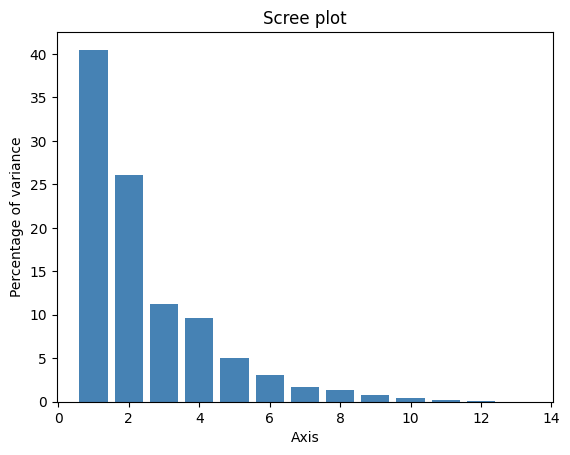

In [328]:
#graphique des vaeurs propres
my_ca.plot_eigenvalues(type="percentage")

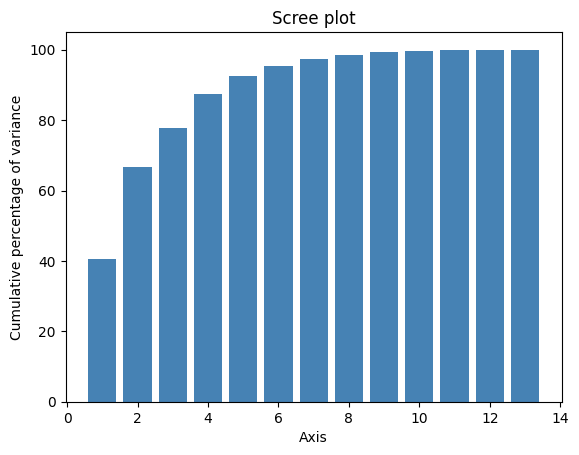

In [329]:
#graphique des vaeurs propres
my_ca.plot_eigenvalues(type="cumulative")

#analyse de la qualité de la représentatio n


Premier axe factoriel:


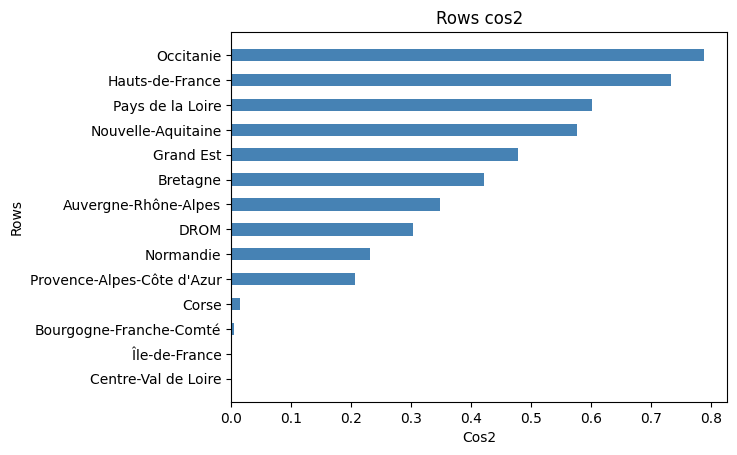

second axe factoriel:


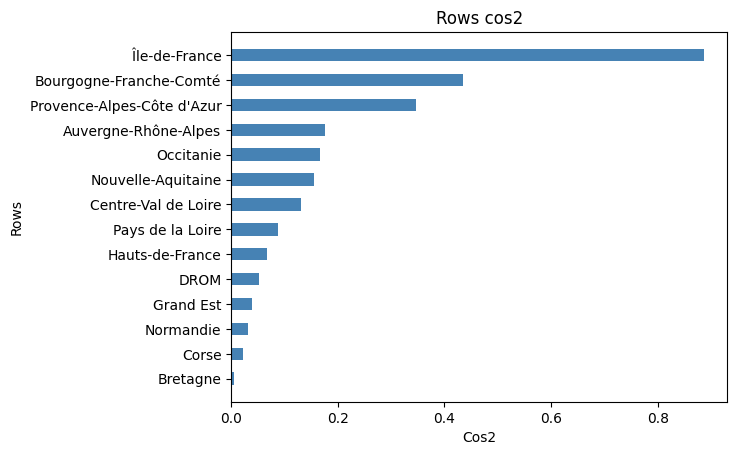

In [332]:
#classement des ponts colonnes en fonction de leur contribution au premier axe
print("Premier axe factoriel:")
my_ca.plot_row_cos2(num_axis=1)
print("second axe factoriel:")
my_ca.plot_row_cos2(num_axis=2)


_sur le premier axe : grand Est, Nouvelle Aquitaine,Pays de la Loire haut de France, Occitanie
_deuxieme axe ile d france

## analyse graphique

#analyse des départemens(profil ligne)

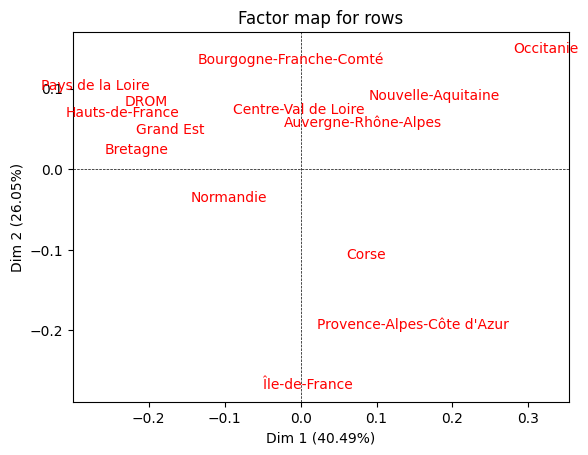

In [330]:
#graphique des département en lignes
my_ca.mapping_row(num_x_axis=1,num_y_axis=2)

Grand est, Pays de la Loire et Haut de France ont les mm pratiques
ile de france particuler
Occitanie et novellle aquitaine différent

Premier axe factoriel:


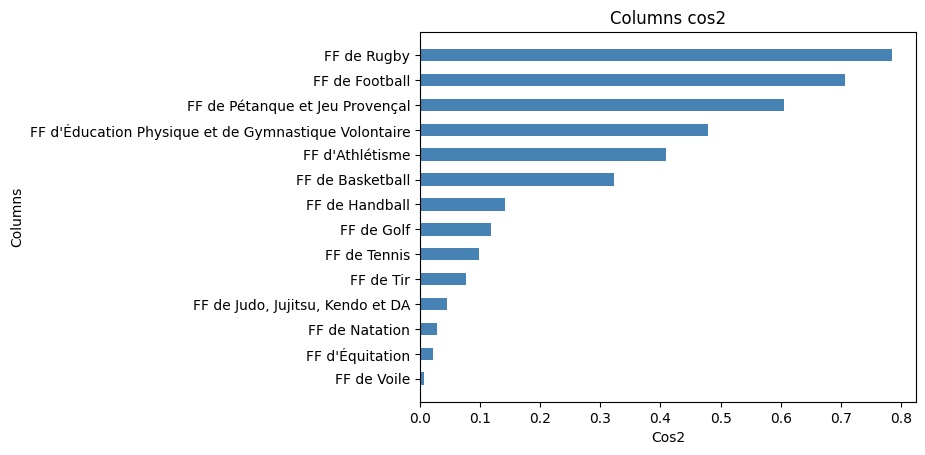

second axe factoriel:


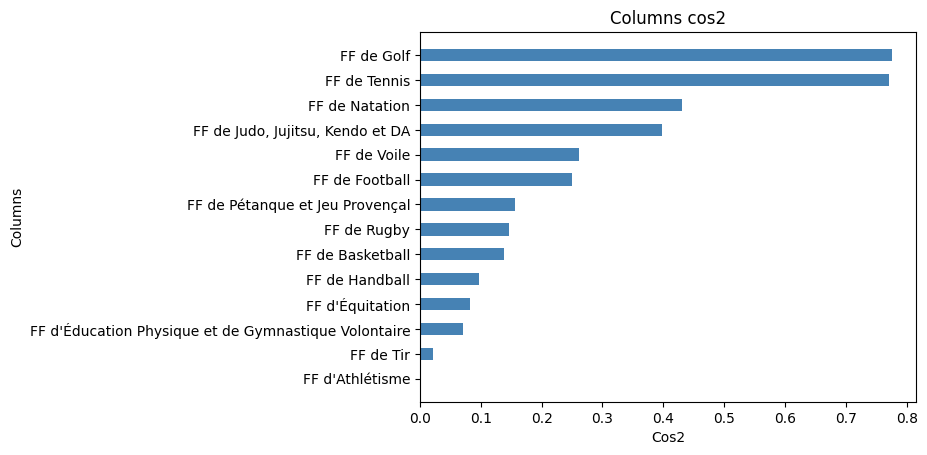

In [333]:
#profil_colonnes les feédérations
print("Premier axe factoriel:")
my_ca.plot_col_cos2(num_axis=1)
print("second axe factoriel:")
my_ca.plot_col_cos2(num_axis=2)

_premier axe: pintanque jeu provincal, footbal, rugby
_deuxieme axe: Tennis et Golf

Premier axe factoriel:


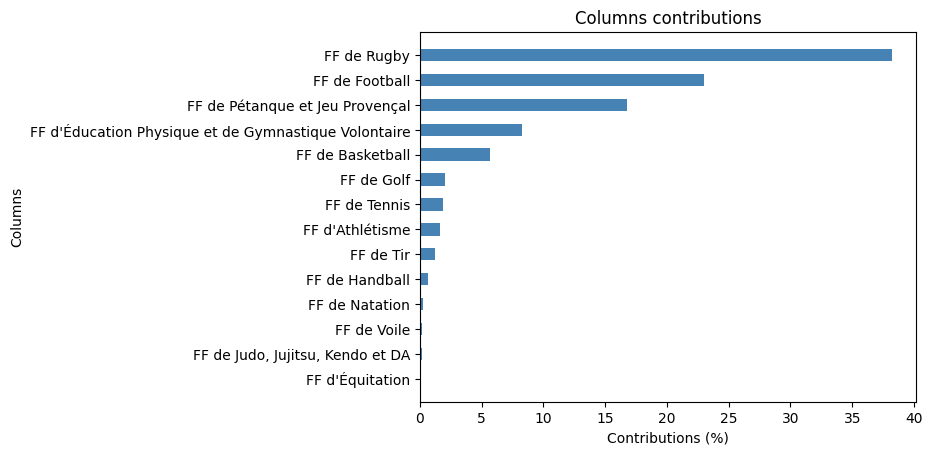

second axe factoriel:


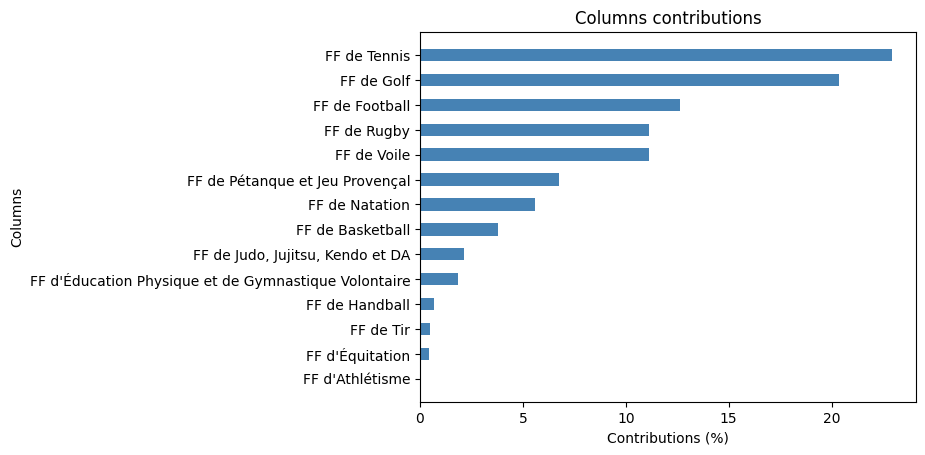

In [336]:
#profil_colonnes les feédérations
print("Premier axe factoriel:")
my_ca.plot_col_contrib(num_axis=1)
print("second axe factoriel:")
my_ca.plot_col_contrib(num_axis=2)

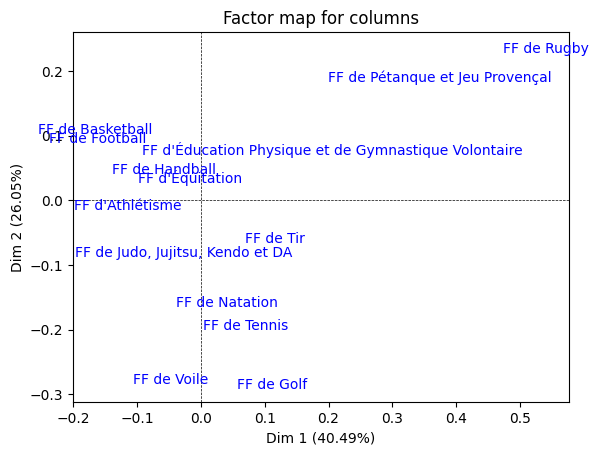

In [334]:
#graphique profil colonne fédération

my_ca.mapping_col(num_x_axis=1,num_y_axis=2)

_le rugby et la pétanque sont  simultanément pratiqués dans les mêmes régions.
les régions qui joue à la pétanque font moins de football. 
_de mm pour le tennis et le golf.

## graphique profil ligne et colonne(superposition)

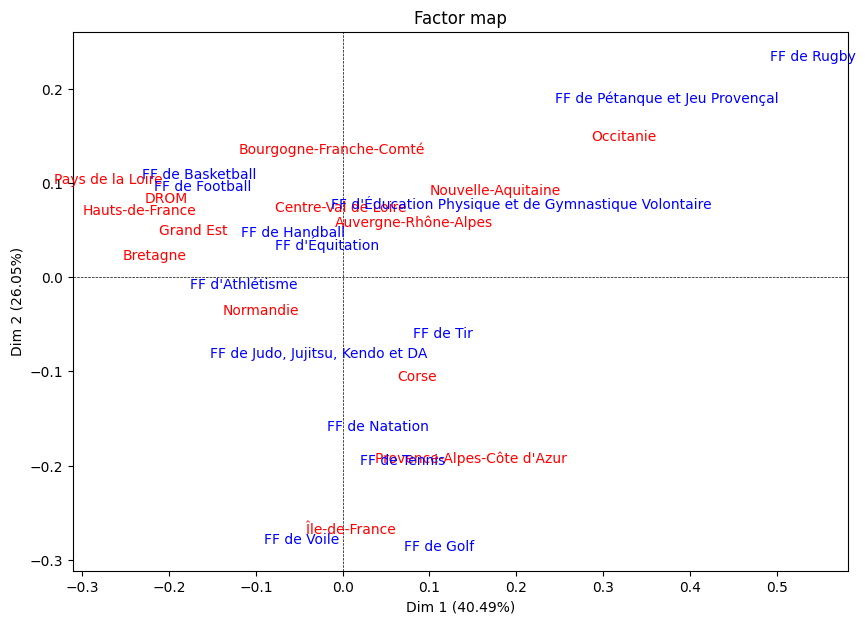

In [335]:
my_ca.mapping(1,2,figsize=(10,7))

In [ ]:
_Grand est, Haut de france, Pays de la Loire sont ceux qui pratiquent plus le  foot.
le nouvelle aquitaine, l'occitanie, joue plus à la pétanquent et au rugby
_Ile de France joue plus Golf et Tennis


#analyse avec ttes les fédérations

In [337]:
base_c=base_pivot.set_index("Région")
base_c

,F Nationale du Sport en Milieu Rural,F Nautique de Pêche Sportive en Apnée,F Sportive des ASPTT,F des Arts Énergétiques et Martiaux Chinois,FF Aéronautique,FF Handisport,FF Motonautique,FF Omnisports des Personnels de l'Éducation Nationale,FF Sportive de Twirling Bâton,FF d'Athlétisme,...,FF des Sports de Glace,"FF des Sports de Traîneau, de Ski VTT Joëring et de Canicross",FF des Échecs,FF du Sport Adapté,FF du Sport Automobile,FF du Sport Boules,FF du Sport Travailliste,FF du Sport d'Entreprise,Union Nationale Sportive Léo Lagrange,Union Nationale des Clubs Universitaires
Région,,,,,,,,,,,,,,,,,,,,,
Auvergne-Rhône-Alpes,3875.0,10.0,14304.0,2181.0,4466.0,3634.0,29.0,1596.0,2776.0,31453.0,...,3729.0,281.0,1811.0,6258.0,6540.0,29130.0,2150.0,574.0,4333.0,18281.0
Bourgogne-Franche-Comté,798.0,4.0,7042.0,548.0,1633.0,2021.0,23.0,109.0,545.0,12551.0,...,1380.0,60.0,737.0,2634.0,3034.0,3229.0,510.0,161.0,1153.0,31.0
Bretagne,4645.0,129.0,7857.0,655.0,1851.0,1429.0,7.0,333.0,1787.0,17731.0,...,1111.0,27.0,1360.0,2602.0,1016.0,307.0,878.0,298.0,872.0,27.0
Centre-Val de Loire,390.0,2.0,11104.0,1142.0,1406.0,795.0,5.0,1040.0,914.0,12415.0,...,1214.0,19.0,789.0,2152.0,1800.0,806.0,652.0,829.0,224.0,846.0
Corse,6.0,34.0,955.0,0.0,351.0,27.0,13.0,0.0,93.0,1652.0,...,0.0,9.0,145.0,49.0,1200.0,2.0,56.0,36.0,0.0,9.0
DROM,206.0,13.0,1488.0,568.0,635.0,527.0,31.0,429.0,1058.0,11629.0,...,3.0,0.0,327.0,360.0,847.0,6.0,946.0,1492.0,4.0,11.0
Grand Est,1501.0,5.0,17889.0,1254.0,2483.0,2710.0,5.0,989.0,1730.0,26133.0,...,3064.0,135.0,2933.0,3050.0,2613.0,578.0,1589.0,2013.0,1194.0,51.0
Hauts-de-France,6238.0,20.0,6464.0,1463.0,2270.0,2532.0,6.0,263.0,1409.0,27672.0,...,1537.0,57.0,1554.0,3537.0,2341.0,930.0,2176.0,196.0,4605.0,8296.0
Normandie,8228.0,165.0,9409.0,359.0,1475.0,595.0,147.0,90.0,1118.0,16169.0,...,1686.0,37.0,985.0,2375.0,2740.0,639.0,352.0,49.0,1830.0,2526.0


In [338]:
my_cac=CA(row_labels=base_c.index.values,col_labels=base_c.columns.values,stats=True)

In [343]:
#Estime AFC( entrainer le afc)
my_cac.fit(base_c.values)

CA(col_labels=<StringArray>
[                         'F Nationale du Sport en Milieu Rural',
                        'F Nautique de Pêche Sportive  en Apnée',
                                          'F Sportive des ASPTT',
                   'F des Arts Énergétiques et Martiaux Chinois',
                                               'FF Aéronautique',
                                                 'FF Handisport',
                                               'FF Motonautique',
         "FF Omnisports des Personnels de l'Éducation Nationale",
                                 'FF Sportive de Twirling Bâton',
                                               "FF d'Athlétisme",
                                                   "FF d'Aviron",
                                            "FF d'Aéromodélisme",
                                              "FF d'Aérostation",...
                         'Union Nationale Sportive Léo Lagrange',
                      'Union Nationale des Clubs Universitaires']
Length: 94, dtype: string,
   row_labels=<StringArray>
[      'Auvergne-Rhône-Alpes',    'Bourgogne-Franche-Comté',
                   'Bretagne',        'Centre-Val de Loire',
                      'Corse',                       'DROM',
                  'Grand Est',            'Hauts-de-France',
                  'Normandie',         'Nouvelle-Aquitaine',
                  'Occitanie',           'Pays de la Loire',
 "Provence-Alpes-Côte d'Azur",              'Île-de-France']
Length: 14, dtype: string)

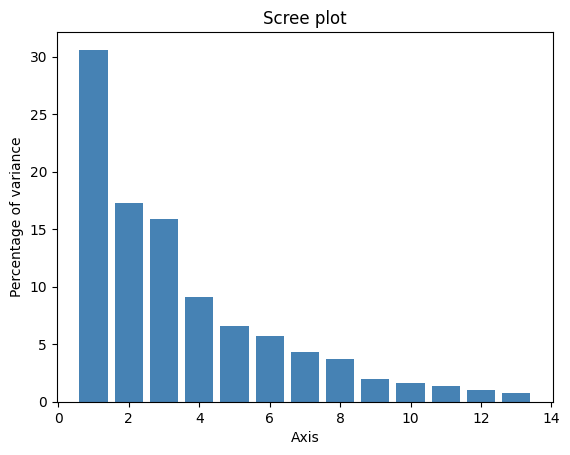

In [344]:
my_cac.plot_eigenvalues(type="percentage")

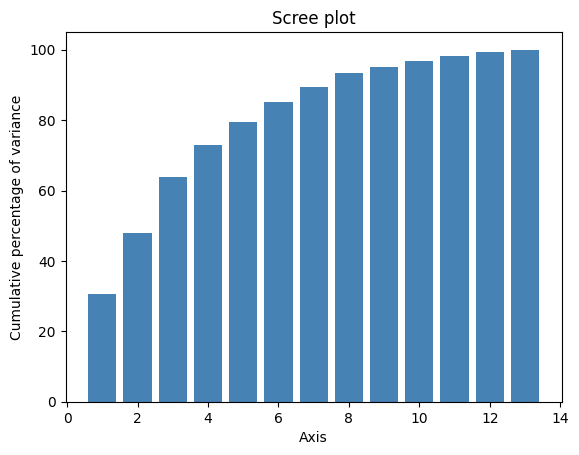

In [346]:
my_cac.plot_eigenvalues(type="cumulative")

Premier axe factoriel:


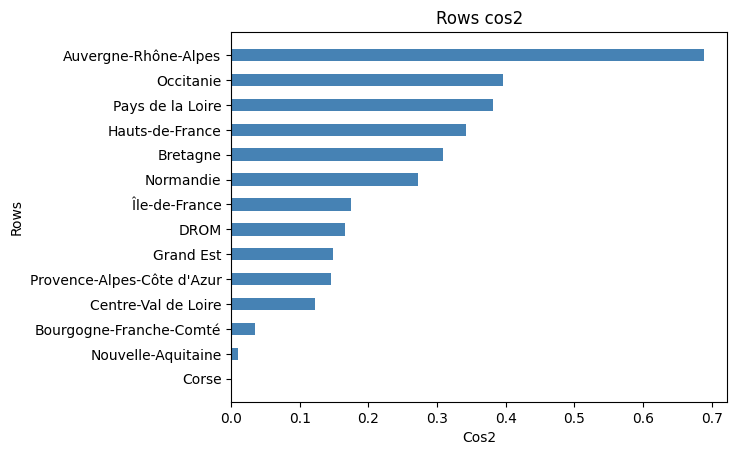

second axe factoriel:


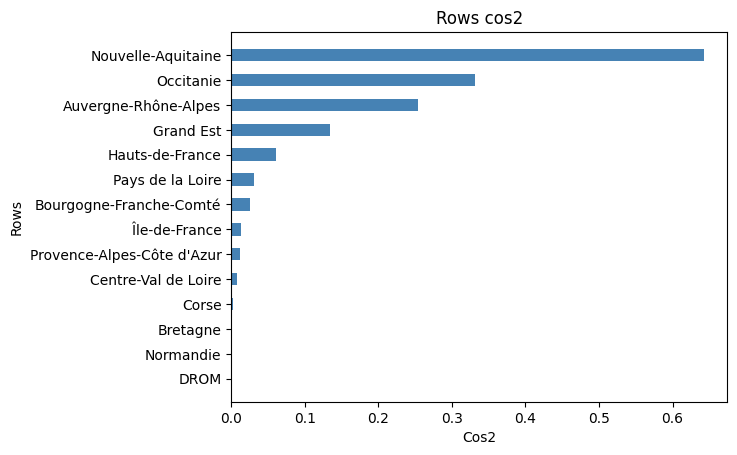

troisieme axe factoriel:


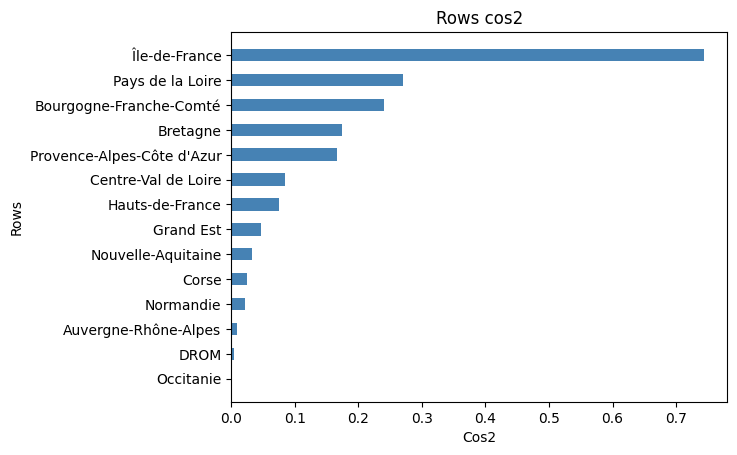

In [348]:
#classement des ponts colonnes en fonction de leur contribution au premier axe
print("Premier axe factoriel:")
my_cac.plot_row_cos2(num_axis=1)
print("second axe factoriel:")
my_cac.plot_row_cos2(num_axis=2)
print("troisieme axe factoriel:")
my_cac.plot_row_cos2(num_axis=3)


Premier axe factoriel:


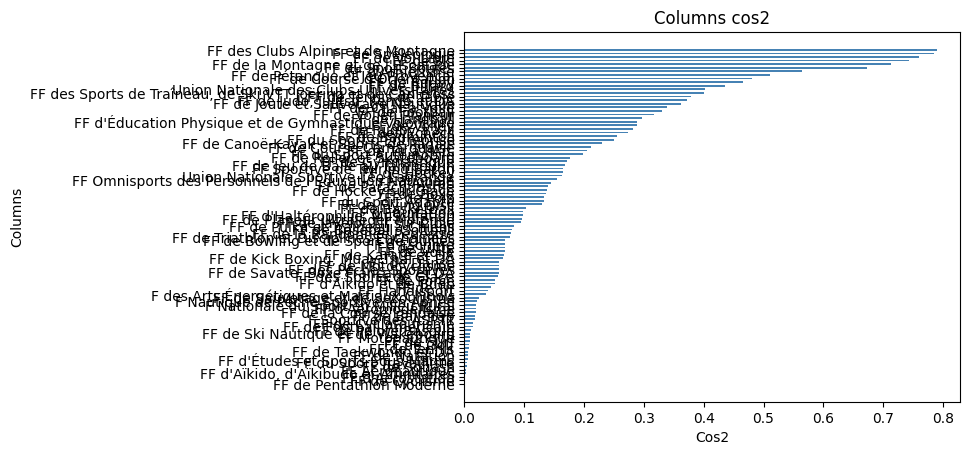

second axe factoriel:


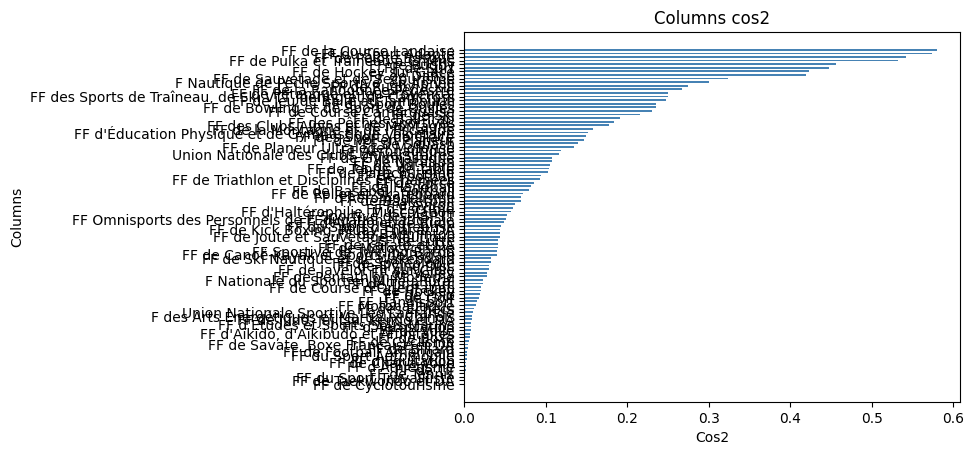

troisieme axe factoriel:


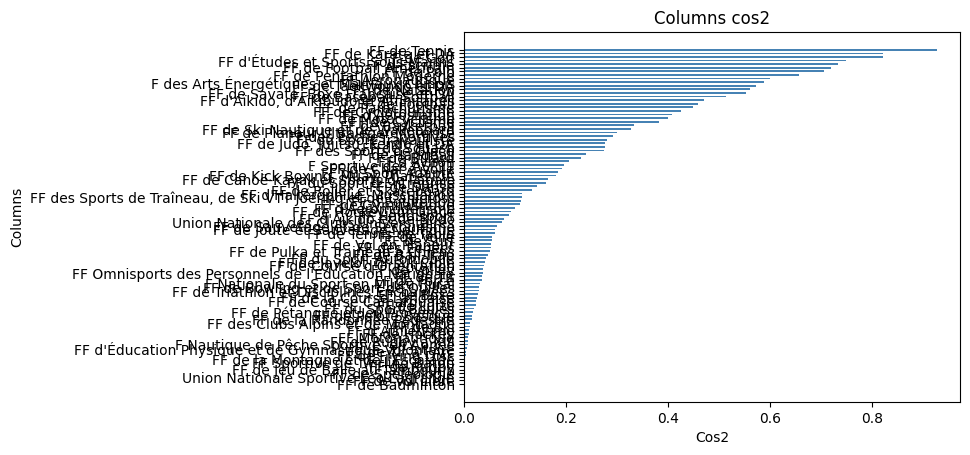

In [351]:
#profil colonnes
print("Premier axe factoriel:")
my_cac.plot_col_cos2(num_axis=1)
print("second axe factoriel:")
my_cac.plot_col_cos2(num_axis=2)
print("troisieme axe factoriel:")
my_cac.plot_col_cos2(num_axis=3)


In [356]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,adjusted_rand_score
from scipy.spatial.distance import cdist
from math import pi